<a href="https://colab.research.google.com/github/Ishan-A-Mardani/SMS-Spam-Detection/blob/main/SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all essential libraries

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import string
import re

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag

import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


# Importing data from csv file

In [36]:
pip install chardet

In [37]:
import chardet

with open(r"spam.csv", 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']

df = pd.read_csv(r"spam.csv",encoding=encoding)
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [38]:
df.shape

(5572, 5)

In [39]:
del df["Unnamed: 2"]
del df["Unnamed: 3"]
del df["Unnamed: 4"]

In [40]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Renaming the Columns

In [183]:
df.rename({"v1":"result","v2":"messages"},inplace=True,axis=1)
df['label'] = df.result.map({"ham":0,"spam":1})

In [184]:
df.head()

,result,messages,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Analysing the Data

In [43]:
df.isna().sum()

result      0
messages    0
dtype: int64

**No null values are present in our dataset**

In [44]:
df["result"].value_counts()

result
ham     4825
spam     747
Name: count, dtype: int64

**The number of instances of ham and spam in our dataset**

<Axes: title={'center': 'Instances vs Classes'}, xlabel='No. of Instances', ylabel='Classes'>

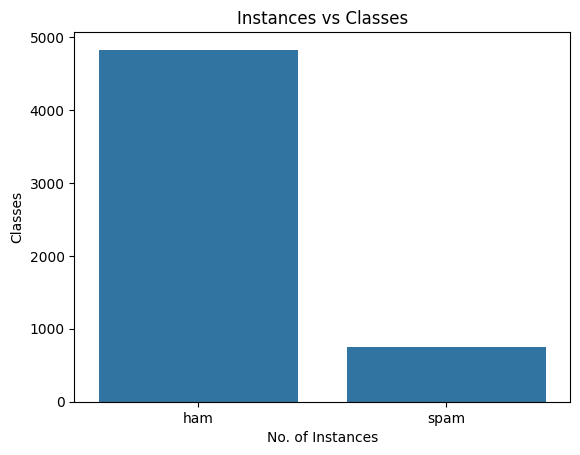

In [45]:
plt.title("Instances vs Classes")
plt.xlabel("No. of Instances")
plt.ylabel("Classes")
sbn.barplot(x=["ham","spam"],y=[df["result"].value_counts()["ham"],df["result"].value_counts()["spam"]])

([<matplotlib.patches.Wedge at 0x7f1c3f071f00>,
 [Text(-1.0038714981945518, 0.4497132587689916, 'ham'),
  Text(1.0038714771419537, -0.44971330576360763, 'spam')],
 [Text(-0.5475662717424827, 0.24529814114672266, '86.6%'),
  Text(0.5475662602592474, -0.2452981667801496, '13.4%')])

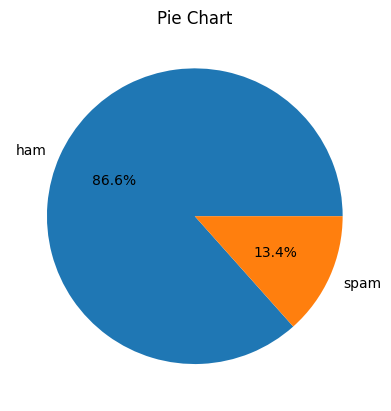

In [46]:
plt.title("Pie Chart")
plt.pie(x=[df["result"].value_counts()["ham"],df["result"].value_counts()["spam"]],labels=["ham","spam"],autopct="%1.1f%%")

# Transforming Textual Data (Data Preprocessing)

In [47]:
# lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() # I have used Stemmer as it was leading to better accuracy.
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:
punctuations = string.punctuation
stop = stopwords.words('english')
stop.extend(punctuations)
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [49]:
corpus=[]
for i in range(0,len(df)):
    # Remove everything but alphanumeric characters.
    review = re.sub('[^a-zA-z0-9]',' ',df.iloc[i]["messages"])
    review = review.lower()
    review = review.split()
    # review = [lemmatizer.lemmatize(word) for word in review if not word in stop]
    review = [stemmer.stem(word) for word in review if not word in stop]
    review = ' '.join(review)
    corpus.append(review)

# Changing Data Format

In [147]:
words=[]
j=0
y=[]
sentences = []
for sent in corpus:
    sent_token = sent_tokenize(sent)
    if(sent!=""):
        y.append(df.iloc[j]['result'])
    j=j+1
    for i in sent_token: # sent_token is a list of one sentence beacuse sent_tokenize returns a list.
        sentences.append(i)
        data = word_tokenize(i)
        words.append(data)

In [51]:
len(corpus)

5572

# word2vec model creation using gensim library

In [52]:
model = Word2Vec(words,window=5,min_count=2,vector_size=20)

In [53]:
model.wv.index_to_key[0:10]

['u', 'call', '2', 'go', 'get', 'ur', '4', 'gt', 'lt', 'come']

# Get mean of word vectors for all the sentences

In [54]:
def avg_word2vec(doc, model):
    word_vectors = [model.wv[word] for word in doc if word in model.wv.index_to_key]

    if not word_vectors:  # If the list is empty
        return np.zeros(model.vector_size)  # Return a zero vector of the same dimensionality as the word vectors

    return np.mean(word_vectors, axis=0)

In [55]:
X = []
for i in range(len(words)):
    # X.append(model.wv.get_mean_vector(words[i]))
    X.append(avg_word2vec(words[i],model))

In [56]:
Y = []
for i in y:
    if i=='ham':
        Y.append(0)
    else:
        Y.append(1)
print(len(X))
print(len(Y))

5565
5565


# Splitting data into Training and Testing

In [187]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.25, stratify = Y)

In [191]:
print(len(x_train))
print(len(x_test))

4173
1392


array([-0.19788434, -0.03634395,  0.32340443,  0.83158916, -0.3077333 ,
       -0.37414494,  0.03002511,  1.0470318 , -0.29568228,  0.29738012,
        0.7875555 , -0.2911953 ,  0.75278336, -0.38280177,  0.68298453,
        0.4891276 ,  0.85386586, -0.39305237, -0.88780695, -1.052986  ],
      dtype=float32)

# MODEL BUILDING

In [174]:
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Support Vector Machine', SVC()),
    ('K Nearest Neighbors', KNeighborsClassifier()),
    # ('Naive Bayes', GaussianNB()),
    ('Multi Layer Perceptron', MLPClassifier()),
    ('Extra Trees', ExtraTreesClassifier()),
    ('Stochastic Gradient Descent', SGDClassifier()),
    ('Cross Gradient Boost', XGBClassifier()),
    ('Cross Gradient Boost (Random Forest)', XGBRFClassifier()),
    ('LightGBM Classifier', LGBMClassifier())
]

In [60]:
best_model=""
best_accuracy=0

In [61]:
for name,model in models:
    model.fit(x_train,y_train)
    y_test_predicted=model.predict(x_test)
    accuracy=accuracy_score(y_test,y_test_predicted)
    if accuracy > best_accuracy:
        best_model= name
        best_accuracy = accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Info] Number of positive: 560, number of negative: 3613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 4173, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.134196 -> initscore=-1.864357
[LightGBM] [Info] Start training from score -1.864357


# RESULTS

In [62]:
print(best_model)
print(best_accuracy)

Extra Trees
0.9633620689655172


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1205
           1       0.90      0.78      0.84       187

    accuracy                           0.96      1392
   macro avg       0.93      0.88      0.91      1392
weighted avg       0.96      0.96      0.96      1392



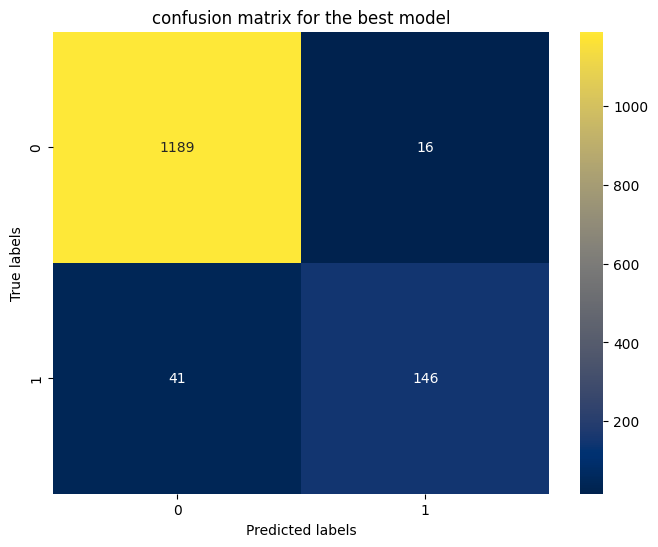

In [63]:
classifier = ExtraTreesClassifier()
classifier.fit(x_train,y_train)
y_predicted = classifier.predict(x_test)
print(classification_report(y_test,y_predicted))
cm = confusion_matrix(y_test,y_predicted)
plt.figure(figsize=(8, 6))
sbn.heatmap(cm, annot=True, cmap='cividis', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("confusion matrix for the best model")
plt.show()

# Using TF-IDF

In [64]:
# Token Frequency(TF) - Inverse Document Frequency(IDF)
# TF = Frequency of token in a Doc / Total number of words in a doc
# DF = Number of Documents the token appears in
# IDF = log(total number of documents / DF)
# Scikit uses: IDF = log(n+1 / DF+1) + 1 to avoid division by zero error.
# Why are we taking inverse DF. This is beacuse if a word appears in a lot of documents, it is a generic word. So, its score should be smaller in a classification model.
# Log is used to dampen the effect of very high frequencies. If word1 appears 5 times and word2 appears 25 times, word2 is more significant.
# But, if word1 appears 1 million times and word2 appears 2 million times, both are almost equally significant.
# This concept is covered by the log.
# TF-IDF = TF*IDF

In [65]:
vectorizer = TfidfVectorizer()

In [185]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df.messages,
    df.label,
    test_size=0.25,
    # random_state=2022,
    stratify = df.label
)

In [159]:
print(X_train.shape)
print(X_test.shape)

(4179,)
(1393,)


In [160]:
def custom_fit(name, model, X_train, Y_train, X_test):
    clf = Pipeline([
        ('vectorizer_tfidf',TfidfVectorizer()),
        (name, model)
    ])

    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    return Y_pred

In [175]:
best_model=""
best_accuracy=0

In [176]:
for name,model in models:
    print(name)
    Y_test_predicted = custom_fit(name,model,X_train,Y_train,X_test)
    accuracy = accuracy_score(Y_test,Y_test_predicted)
    print(accuracy)
    if accuracy > best_accuracy:
        best_model = name
        best_accuracy = accuracy

Logistic Regression
0.9662598707824839
Decision Tree
0.9504666188083274
Random Forest
0.9676956209619526
Support Vector Machine
0.9813352476669059
K Nearest Neighbors
0.8973438621679828
Multi Layer Perceptron
0.9834888729361091
Extra Trees
0.9791816223977028
Stochastic Gradient Descent
0.9870782483847811
Cross Gradient Boost
0.9705671213208902
Cross Gradient Boost (Random Forest)
0.9447236180904522
LightGBM Classifier
[LightGBM] [Info] Number of positive: 560, number of negative: 3619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12307
[LightGBM] [Info] Number of data points in the train set: 4179, number of used features: 443
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.134003 -> initscore=-1.866016
[LightGBM] [Info] Start training from score -1.866016
0.9763101220387652


In [177]:
print(best_model)
print(best_accuracy)

Stochastic Gradient Descent
0.9870782483847811


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1206
           1       0.98      0.91      0.94       187

    accuracy                           0.99      1393
   macro avg       0.98      0.95      0.97      1393
weighted avg       0.99      0.99      0.99      1393



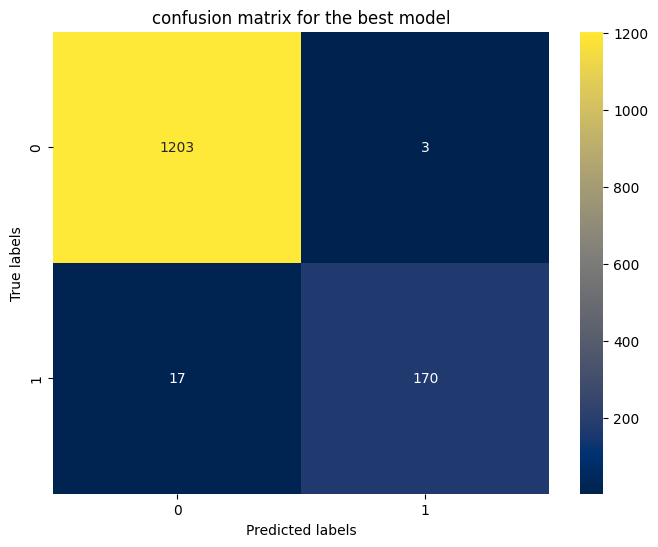

In [180]:
Y_predicted = custom_fit('Stochastic Gradient Descent', SGDClassifier(), X_train, Y_train, X_test)
accuracy=accuracy_score(Y_test,Y_predicted)
print(classification_report(Y_test,Y_predicted))
cm = confusion_matrix(Y_test,Y_predicted)
plt.figure(figsize=(8, 6))
sbn.heatmap(cm, annot=True, cmap='cividis', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("confusion matrix for the best model")
plt.show()

# Using RNN (LSTM)

In [231]:
# number of words used as features
max_features = 8000
# cut off the words after seeing 500 words in each document(email)
maxlen = 500

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

word_index = tokenizer.word_index
print("Found {0} unique words: ".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

print("data shape: ", data.shape)

Found 7222 unique words: 
data shape:  (5565, 500)


In [232]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(data),
    np.array(Y),
    test_size=0.25,
    # random_state=2022,
    stratify = np.array(Y)
)

In [233]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [234]:
history_ltsm = model.fit(x_train, y_train, epochs=10, batch_size=60, validation_split=0.2)

Epoch 1/10
56/56 [==============================] - 24s 392ms/step - loss: 0.3638 - acc: 0.8703 - val_loss: 0.2201 - val_acc: 0.9377
Epoch 2/10
56/56 [==============================] - 15s 268ms/step - loss: 0.1568 - acc: 0.9575 - val_loss: 0.1117 - val_acc: 0.9749
Epoch 3/10
56/56 [==============================] - 15s 266ms/step - loss: 0.0870 - acc: 0.9820 - val_loss: 0.0643 - val_acc: 0.9844
Epoch 4/10
56/56 [==============================] - 16s 292ms/step - loss: 0.0539 - acc: 0.9880 - val_loss: 0.0453 - val_acc: 0.9880
Epoch 5/10
56/56 [==============================] - 15s 263ms/step - loss: 0.0361 - acc: 0.9910 - val_loss: 0.0389 - val_acc: 0.9868
Epoch 6/10
56/56 [==============================] - 15s 266ms/step - loss: 0.0256 - acc: 0.9955 - val_loss: 0.0380 - val_acc: 0.9868
Epoch 7/10
56/56 [==============================] - 15s 272ms/step - loss: 0.0458 - acc: 0.9847 - val_loss: 0.0486 - val_acc: 0.9892
Epoch 8/10
56/56 [==============================] - 15s 272ms/step - 

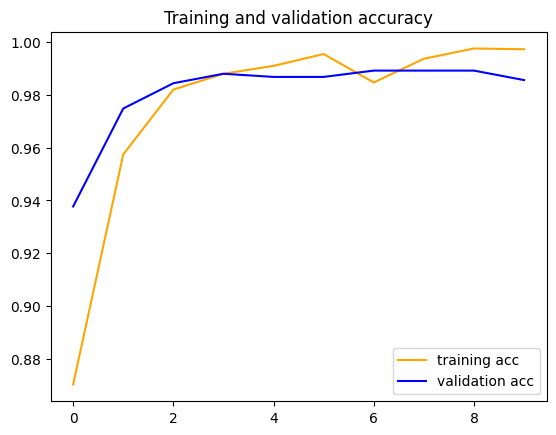

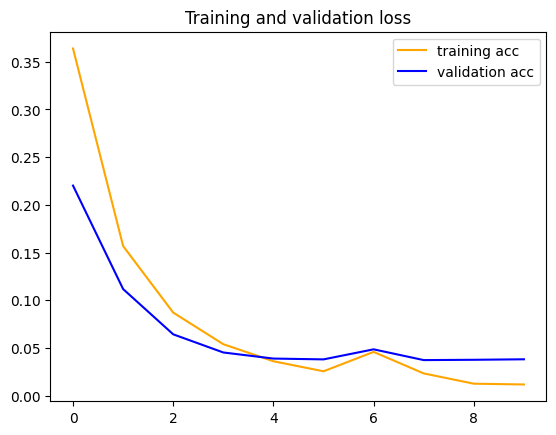

In [235]:
acc = history_ltsm.history['acc']
val_acc = history_ltsm.history['val_acc']
loss = history_ltsm.history['loss']
val_loss = history_ltsm.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training acc')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [238]:
predict_proba = model.predict(x_test)
pred = np.argmax(predict_proba, axis=-1)
acc = model.evaluate(x_test, y_test)
from sklearn.metrics import confusion_matrix
print("Test loss is {0:.2f} accuracy is {1:.3f}  ".format(acc[0],acc[1]))

44/44 [==============================] - 5s 110ms/step - loss: 0.0364 - acc: 0.9885
Test loss is 0.04 accuracy is 0.989  
